## 3.1 线性回归

### 3.1.2 矢量化加速

In [1]:
%matplotlib inline

import math
import time
import numpy as np  
import torch
from d2l import torch as d2l

In [3]:
n = 100
a = torch.ones([n])
b = torch.ones([n])

In [4]:
# 通用类：Timer 计时器

class Timer: #@save

  """记录多次运行时间"""
  def __init__(self):
    self.times = []
    self.start()

  def start(self):
    """启动计时器"""
    self.tik = time.time()
  
  def stop(self):
    """停止计时器并将时间记录在列表中"""
    self.times.append(time.time() - self.tik)
    return self.times[-1]
  
  def avg(self):
    """返回平均时间"""
    return sum(self.times) / len(self.times)

  def sum(self):
    """返回时间总和"""
    return sum(self.times)

  def cumsum(self):
    """返回累计时间"""
    return np.array(self.times).cumsum().tolist()

In [11]:
# n = 100
c = torch.zeros(n)
timer = Timer()
for i in range(n):
  a[i] = a[i] + b[i]

# 计算100个张量相加的时间
f'{timer.stop():.5f}'.format(timer)

'0.00199'

In [14]:
timer.start()
d = a + b
f'{timer.stop():.5f}'.format(timer)

'0.00000'

### 3.1.3 正态分布与平方损失

In [15]:
# 将x进行正态化
def normal(x, mu, sigma):
  p = 1 / math.sqrt(2 * math.pi * sigma **2 )
  return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

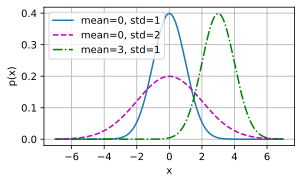

In [17]:
x = np.arange(-7, 7, 0.01)

params = [(0, 1), (0, 2), (3, 1)]

d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], 
         xlabel='x', ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean={mu}, std={sigma}' for mu, sigma in params])

### 练习

不会

## 3.2 线性回归的从0开始实现

In [18]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

### 3.2.1 生成数据集

In [27]:
"""
生成人造数据集
w是真实的权重，b是真实的偏置，num_examples是生成的数量
X相当于 num_examples行，len(w)列的向量；y相当于对应的y值，但是需要在y上加上噪声，以生成人造数据集。
"""
def synthetic_data(w, b, num_examples): #@save
  X = torch.normal(0, 1, (num_examples, len(w)))
  y = torch.matmul(X, w) + b
  y += torch.normal(0, 0.01, y.shape)
  return X, y.reshape((-1, 1))

In [28]:
# 设置真实的w和b，调用函数生成数据集。
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [29]:
print('features: ', features[0], '\nlabel: ', labels[0])

features:  tensor([-0.1356, -1.0494]) 
label:  tensor([7.4947])


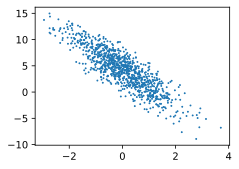

In [30]:
d2l.set_figsize()

# 查看数据集分布
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

### 3.2.2 读取数据集

In [31]:
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  # 打乱数据的顺序
  random.shuffle(indices)
  # 分批次，以迭代器的形式，取出数据
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
    yield features[batch_indices], labels[batch_indices]

In [32]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
  print(X, '\n', y)
  break

tensor([[ 0.1506, -0.4175],
        [ 0.1161, -0.4037],
        [-2.1070,  0.3982],
        [ 0.0093, -0.9161],
        [ 0.8959, -0.8673],
        [-0.9681, -0.2875],
        [ 0.9135,  0.4895],
        [-1.3368, -0.2717],
        [-0.0448, -0.6933],
        [ 0.0088,  1.4846]]) 
 tensor([[ 5.9170],
        [ 5.8159],
        [-1.3686],
        [ 7.3176],
        [ 8.9513],
        [ 3.2489],
        [ 4.3609],
        [ 2.4469],
        [ 6.4760],
        [-0.8228]])


### 3.2.3 初始化模型参数

In [33]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 3.2.4 定义模型

In [34]:
def linreg(X, w, b): #@save
  return torch.matmul(X, w) + b

### 3.2.5 定义损失函数

In [35]:
def squared_loss(y_hat, y): #@save
  return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6 定义优化算法


In [36]:
def sgd(params, lr, batch_size): #@save
  with torch.no_grad():
    for param in params:
      # 样本的平均梯度
      param -= lr * param.grad / batch_size
      param.grad.zero_()

### 3.2.7 训练

In [49]:
lr = 0.02
num_epochs = 10
batch_size = 20
net = linreg
loss = squared_loss

In [50]:
for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y)
    l.sum().backward()
    sgd([w,b], lr, batch_size)
  
  with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f'epoch{epoch + 1}, loss {float(train_l.mean()):f}')

epoch1, loss 0.000048
epoch2, loss 0.000048
epoch3, loss 0.000048
epoch4, loss 0.000048
epoch5, loss 0.000048
epoch6, loss 0.000048
epoch7, loss 0.000048
epoch8, loss 0.000048
epoch9, loss 0.000048
epoch10, loss 0.000048


### 练习

1. 权重为0的时候的情况

In [59]:
w = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y)
    l.sum().backward()
    sgd([w,b], lr, batch_size)
  
  with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f'epoch{epoch + 1}, loss {float(train_l.mean()):f}')

epoch1, loss 2.335020
epoch2, loss 0.350923
epoch3, loss 0.053342


2. 没学过电流电压的关系。
3. 什么是普朗克定律？？
4. 不知道
5. y_hat可能有多种不同的形状，可能是一个多维数组。使用reshape可以保证yhat和y有相同的形状。

6. 不同学习率的时候有什么变化

In [60]:
lr = 0.001

for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    l = loss(net(X, w, b), y)
    l.sum().backward()
    sgd([w,b], lr, batch_size)
  
  with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f'epoch{epoch + 1}, loss {float(train_l.mean()):f}')

epoch1, loss 0.000048
epoch2, loss 0.000048
epoch3, loss 0.000048
epoch4, loss 0.000048
epoch5, loss 0.000048
epoch6, loss 0.000048
epoch7, loss 0.000048
epoch8, loss 0.000048
epoch9, loss 0.000048
epoch10, loss 0.000048


7. 最后一轮会直接拿出来剩下的所有样本进行学习。

## 3.3 线性回归的简洁实现

### 3.3.1 生成数据集

In [74]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [75]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 3.3.2 读取数据集

In [76]:
"""
既然我们可以自己写，数据加载器，那么为什么还要使用Pytorch提供的数据加载器呢？
1. 提供了一个标准化的接口，可以与 PyTorch 生态系统中的其他工具和库无缝集成。
2. 自动处理数据的批处理和打乱
3. DataLoader 支持多线程和多进程数据加载，这可以显著提高数据加载的速度，特别是在处理大规模数据集和使用大型模型时。
4. 可以处理各种边缘情况
"""

def load_array(data_arrays, batch_size, is_train=True): #@save
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [77]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [78]:
next(iter(data_iter))

[tensor([[ 1.9936, -0.2262],
         [-0.6320, -0.3352],
         [ 0.8906,  1.0490],
         [ 0.6734, -0.3260],
         [-1.2593,  0.4420],
         [-0.5461,  0.6763],
         [ 0.3393, -0.8253],
         [-0.2733,  0.8441],
         [-1.6828,  0.5846],
         [-1.1504,  0.1680]]),
 tensor([[ 8.9443],
         [ 4.0776],
         [ 2.4235],
         [ 6.6578],
         [ 0.1770],
         [ 0.8026],
         [ 7.6818],
         [ 0.7848],
         [-1.1532],
         [ 1.3367]])]

### 3.3.3 定义模型

In [65]:
from torch import nn

In [66]:
net = nn.Sequential(nn.Linear(2, 1))

### 3.3.4 初始化模型参数

In [69]:
# 后面带有下划线的方法可以用来重写参数值

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [70]:
net[0].weight.data, net[0].bias.data, 

(tensor([[-0.0020,  0.0043]]), tensor([0.]))

### 3.3.5 定义损失函数

In [71]:
loss = nn.MSELoss()

### 3.3.6 定义优化算法

In [72]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 3.3.7 训练

In [79]:
num_epochs = 3
for expoch in range(num_epochs):
  for X, y in data_iter:
    l = loss(net(X), y)
    trainer.zero_grad()
    l.backward()
    trainer.step()
  l = loss(net(features), labels)
  print(f'epoch{epoch + 1}, loss{l:f}')

epoch10, loss0.000253
epoch10, loss0.000106
epoch10, loss0.000106


In [80]:
w = net[0].weight.data
print('w的估计误差: ', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差: ', true_b - b)

w的估计误差:  tensor([-0.0007,  0.0005])
b的估计误差:  tensor([0.0006])


### 练习

1. 总损失替换为平均损失，需要把新的学习率换为原来学习率 * batch_size

2. 用Huber损失代替原损失

In [81]:
loss = nn.HuberLoss()

num_epochs = 3
for expoch in range(num_epochs):
  for X, y in data_iter:
    l = loss(net(X), y)
    trainer.zero_grad()
    l.backward()
    trainer.step()
  l = loss(net(features), labels)
  print(f'epoch{epoch + 1}, loss{l:f}')

epoch10, loss0.000052
epoch10, loss0.000053
epoch10, loss0.000052


3. 梯度如何访问

In [103]:
net[0].weight.grad, net[0].bias.grad

(tensor([[-0.0074,  0.0015]]), tensor([-0.0065]))

## 3.5 图像分类数据集

In [82]:
%matplotlib inline
import torch 
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

### 3.5.1 读取数据集

In [83]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
  root='./data', train=True, transform=trans, download=True)

mnist_test = torchvision.datasets.FashionMNIST(
  root='./data', train=False, transform=trans, download=True)

In [84]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [85]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [86]:
# 返回对应的标签

def get_fasion_mnist_labels(labels): #@save
  text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
                 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
  return [text_labels[int(i)] for i in labels]

In [87]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
  # 设置图片总大小
  figsize = (num_cols * scale, num_rows * scale)
  # 获取所有的子图
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
  # 子图平铺以用循环进行控制
  axes = axes.flatten()
  # 展示所有的图片
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):
      ax.imshow(img.numpy())
    else :
      ax.imshow(img)
    # 隐藏所有的xy轴
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    # 设置标题为标签相应的类型
    if titles:
      ax.set_title(titles[i])
  return axes

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

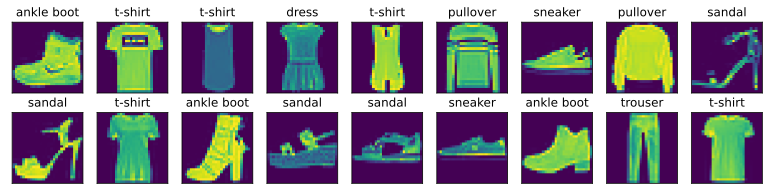

In [88]:
# 获取前10个图像
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
# 展示前10个图像
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fasion_mnist_labels(y))

### 3.5.2 读取小批量

In [89]:
batch_size = 256

# 4个线程同时开始工作
def get_dataloader_warkers(): #@save
  return 4

# 获取训练集迭代器
trainer_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_warkers())

In [90]:
timer = d2l.Timer()
for X, y in trainer_iter:
  continue
f'{timer.stop():2f} sec'

'5.301214 sec'

### 3.5.3 整合所有组件

In [120]:
def load_data_fashion_mnist(batch_size, resize=None): #@save
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  
  mnist_train = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=trans, download=True)

  mnist_test = torchvision.datasets.FashionMNIST(
    root='./data', train=False, transform=trans, download=True)
  
  return (
    data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_warkers()),
    data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=get_dataloader_warkers())
  )

In [121]:
trainer_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in trainer_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


### 练习

1. 减少batchsize是否影响读取性能

In [122]:
trainer_iter = data.DataLoader(mnist_train, 1, shuffle=True, num_workers=get_dataloader_warkers())

timer = d2l.Timer()
for X, y in trainer_iter:
  continue
f'{timer.stop():2f} sec'

'18.755013 sec'

如上所示，影响很大

2. 

3.其他数据集的示例

In [124]:
help(torchvision.datasets.CIFAR10)

Help on class CIFAR10 in module torchvision.datasets.cifar:

class CIFAR10(torchvision.datasets.vision.VisionDataset)
 |  CIFAR10(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False) -> None
 |  
 |  `CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
 |  
 |  Args:
 |      root (string): Root directory of dataset where directory
 |          ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
 |      train (bool, optional): If True, creates dataset from training set, otherwise
 |          creates from test set.
 |      transform (callable, optional): A function/transform that takes in an PIL image
 |          and returns a transformed version. E.g, ``transforms.RandomCrop``
 |      target_transform (callable, optional): A function/transform that takes in the
 |          target and transforms it.
 |      download (bool, optional): If true, downloads the dataset f

## 3.6 softmax回归从0开始实现

In [91]:
import torch
from IPython import display
from d2l import torch as d2l

In [92]:
batch_size = 256
# 获取训练集和测试集的迭代器
trainer_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 3.6.1 初始化模型参数

In [93]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

### 3.6.2 定义softmax操作

In [94]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [95]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim=True)
  return X_exp / partition

In [96]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(dim=1)

(tensor([[0.1784, 0.1935, 0.1020, 0.2960, 0.2301],
         [0.1912, 0.1802, 0.4102, 0.0639, 0.1545]]),
 tensor([1.0000, 1.0000]))

### 3.6.3 定义模型

In [97]:
def net(X):
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

### 3.6.4 定义损失函数

In [98]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [99]:
def cross_entropy(y_hat, y):
  return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 3.6.5 分类精度

In [103]:
# 返回正确分类的样本数量
def accuracy(y_hat, y): #@save
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
  cmp = y_hat.type(y.dtype) == y
  return float(cmp.type(y.dtype).sum())

In [104]:
accuracy(y_hat, y) / len(y)

0.5

In [102]:
class Accumulator: #@save
  def __init__(self, n):
    self.data = [0.0] * n
  # self.data的多个值可以同时更新  
  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]
  # 重置所有值
  def reset(self):
    self.data = [0.0] * len(self.data)
  # 可以使用方括号获取索引
  def __getitem__(self, idx):
    return self.data[idx]

In [13]:
def evaluate_accuracy(net, data_iter):
  if isinstance(net, torch.nn.Module):
    # 模型设置为评估模式。这主要影响模型中的特定层（BatchNorm和Dropout）
    net.eval()
  # 有两个值的计数器  
  metric = Accumulator(2)
  # 前向传播计算准确度
  with torch.no_grad():
    for X, y in data_iter:
      # 计数：正确分类的样本数量，总样本数量。
      metric.add(accuracy(net(X), y), y.numel())
  
  return metric[0] / metric[1]

In [14]:
evaluate_accuracy(net, test_iter)

0.0434

### 3.6.6 训练

In [105]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    # 把模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 3个计数器：训练损失总和、训练准确度总、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [17]:
"""
以动画的方式绘制数据
-> 如何实现的以动画的方式绘制数据图？
是通过add函数实现的。



"""
class Animator: #@save
  def __init__(self, xlabel=None, ylabel=None, legend=None,
               xlim=None, ylim=None, xscale='linear', yscale='linear',
               fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
               figsize=(3.5, 2.5)):
    if legend is None:
      legend = []
    d2l.use_svg_display()
    
    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)

    if nrows * ncols == 1:
      self.axes = [self.axes, ]

    self.config_axes = lambda: d2l.set_axes(
      self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    
    self.X, self.Y, self.fmts = None, None, fmts

  def add(self, x, y):
    # 向图表中添加多个数据点
    if not hasattr(y, "__len__"):
      y = [y]
    n = len(y)
    
    if not hasattr(x, "__len__"):
      x = [x] * n
    
    if not self.X:
      self.X = [[] for _ in range(n)]
      
    if not self.Y:
      self.Y = [[] for _ in range(n)]

    for i, (a, b) in enumerate(zip(x, y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    
    self.axes[0].cla()

    for x, y, fmt in zip(self.X, self.Y, self.fmts):
      self.axes[0].plot(x, y, fmt)
    
    self.config_axes()
    
    display.display(self.fig)
    display.clear_output(wait=True)

In [1]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [19]:
lr = 0.1

def updater(batch_size):
  return d2l.sgd([W, b], lr, batch_size)

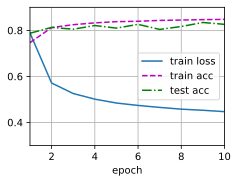

In [20]:
num_epochs = 10
train_ch3(net, trainer_iter, test_iter, cross_entropy, num_epochs, updater)

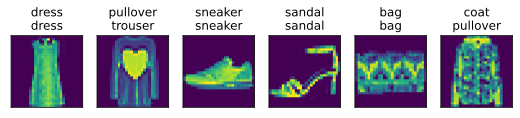

In [24]:
from symbol import break_stmt


def predict_ch3(net, test_iter, n=6): #@save
  for X, y in test_iter:
    break_stmt
  
  trues = d2l.get_fashion_mnist_labels(y)
  preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))

  titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
  d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

### 练习

1. 可能会溢出
2. log里面可能为0
3. 加上一个微小的偏置值
4. 应该对概率的阈值也有要求
5. 运行效率低

## 3.7 softmax回归的简洁实现

In [106]:
import torch
from torch import nn
from d2l import torch as d2l

In [107]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 3.7.1 初始化模型参数

In [108]:
# 先展平，然后传入线性层
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
# 初始化权重
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

### 3.7.2 重新审视Softmax的实现

In [109]:
loss = nn.CrossEntropyLoss(reduction='none')

### 3.7.3 优化算法

In [110]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

### 3.7.4 训练

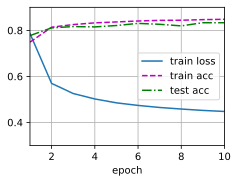

In [30]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

1. 简单调参并查看结果

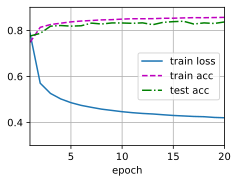

In [111]:
num_epochs = 20
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

2. 过拟合问题。